# Simulating a one-dimensional flow along a Length and in time

 - taking a certain velocity and a certain length.
 - defining an initial condition.
 - solving ode to get time and space responses.
 - velocity reconstruction.
 - phase-shift detection methods.
 - solve for changing velocity and length.

In [43]:
import vtk
import numpy as np
from scipy.integrate import odeint
from scipy.signal import correlate
import matplotlib.pyplot as plt
import sympy as sp

In [66]:
velocity = 2 #cm/s
Length = 10 #cm

mean = 800
st_dev = 100
C0 = st_dev*np.random.randn(100) + mean
step = (Length)/C0.size
length_array = np.arange(0, Length, step)

length_array.size

100

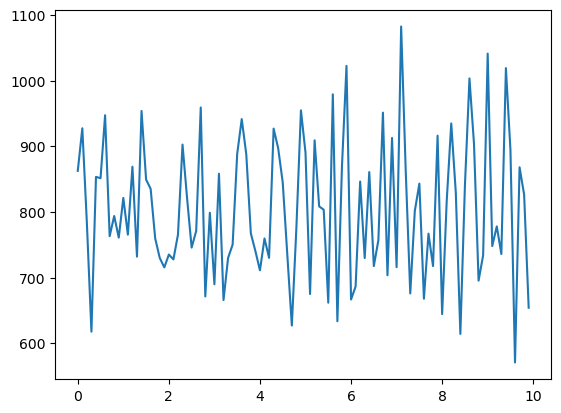

In [67]:
plt.figure()
plt.plot(length_array, C0)

$$
\frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2} - v \frac{\partial C}{\partial x}.
$$

in a simpler form:

$$
\frac{\partial C}{\partial t} = - v \frac{\partial C}{\partial x}.
$$

In [68]:
t, x = sp.symbols('t x')
C = sp.Function('C')(t, x)

D = 0.04
v = velocity

pde = sp.Eq(sp.diff(C, t), - v*sp.diff(C, x))

solution = sp.pdsolve(pde, initial_conditions={C.subs(t, 0): C0})

In [69]:
solution

Eq(C(t, x), F(2*t - x))

In [70]:
time_points = np.linspace(0, 5, 100)
time_points.size


100

In [71]:
C_xt = np.zeros((time_points.size, length_array.size))
for i, t_val in enumerate(time_points):
    x_source = length_array - velocity*t_val
    C_xt[i, :] = np.interp(x_source, length_array, C0, left=mean, right=mean)

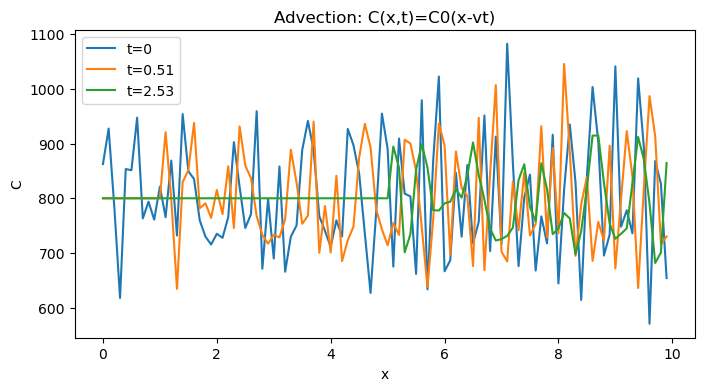

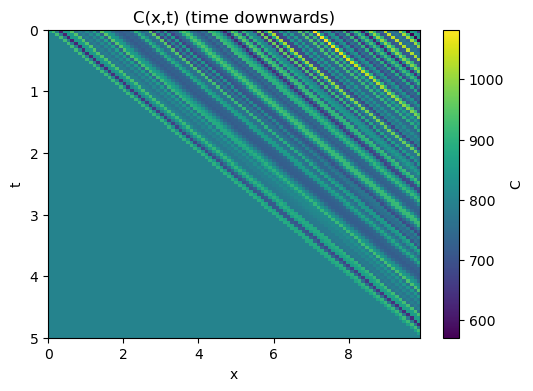

In [72]:
x = length_array
plt.figure(figsize=(8,4))
plt.plot(x, C0, label='t=0')
plt.plot(x, C_xt[10], label=f't={time_points[10]:.2f}')
plt.plot(x, C_xt[50], label=f't={time_points[50]:.2f}')
plt.legend(); plt.xlabel('x'); plt.ylabel('C'); plt.title('Advection: C(x,t)=C0(x-vt)')

plt.figure(figsize=(6,4))
plt.imshow(C_xt, aspect='auto', extent=[x[0], x[-1], time_points[-1], time_points[0]])
plt.colorbar(label='C'); plt.xlabel('x'); plt.ylabel('t'); plt.title('C(x,t) (time downwards)')
plt.show()

Estimated velocity: 1.98 cm/s (True velocity: 2 cm/s)


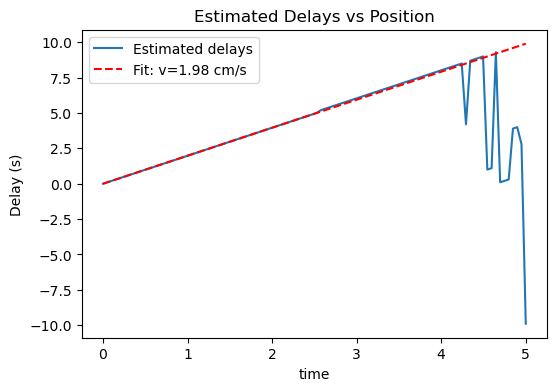

In [74]:
ref = C_xt[0,:]
dt = time_points[1] - time_points[0]
dx = length_array[1] - length_array[0]

delays = np.zeros(C_xt.shape[0])
for i in range(C_xt.shape[0]):
    corr = correlate(C_xt[i,:] - np.mean(C_xt[i,:]), ref - np.mean(ref), mode='full')
    delay_idx = np.argmax(corr) - (len(ref) - 1)
    delays[i] = delay_idx * dx

m,b = np.polyfit(time_points[time_points<1], delays[time_points<1], 1)
v_estimated = m
print(f'Estimated velocity: {v_estimated:.2f} cm/s (True velocity: {velocity} cm/s)')

plt.figure(figsize=(6,4))
plt.plot(time_points, delays, label='Estimated delays')
plt.plot(time_points, m*time_points + b, 'r--', label=f'Fit: v={v_estimated:.2f} cm/s')
plt.xlabel('time'); plt.ylabel('Delay (s)'); plt.title('Estimated Delays vs Position'); plt.legend()
plt.show()